In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('cybersecurity_intrusion_data.csv')
df.head(1)

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1


# About the Dataset
This cybersecurity intrusion dataset contains network session information with features like packet size, protocol type, login attempts, session duration, encryption used, and more. Our goal is to use unsupervised learning (K-means clustering) to identify patterns and detect potential security anomalies without relying on pre-labeled attack data.

In [19]:
df.shape

(9537, 11)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [23]:
df.drop(['session_id', 'attack_detected'], axis=1, inplace=True)

In [25]:
df.head(1)

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
0,599,TCP,4,492.983263,DES,0.606818,1,Edge,0


In [27]:
df.isnull().sum()

network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
dtype: int64

In [29]:
imputer = SimpleImputer(strategy='most_frequent')
df['encryption_used'] = imputer.fit_transform(df[['encryption_used']]).ravel()

In [31]:
df.duplicated().sum()

0

In [33]:
cat = ['protocol_type', 'encryption_used', 'browser_type']

for i in cat:
    print(df[i].unique())

['TCP' 'UDP' 'ICMP']
['DES' 'AES']
['Edge' 'Firefox' 'Chrome' 'Unknown' 'Safari']


In [35]:
protocol_map = {'TCP': 0, 'UDP': 1, 'ICMP': 2}
encryption_map = {'DES': 0, 'AES': 1}
browser_map = {'Edge': 0, 'Firefox': 1, 'Chrome': 2, 'Unknown': 3, 'Safari': 4}

df['protocol_type'] = df['protocol_type'].map(protocol_map)
df['encryption_used'] = df['encryption_used'].map(encryption_map)
df['browser_type'] = df['browser_type'].map(browser_map)

In [37]:
df.head(1)

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
0,599,0,4,492.983263,0,0.606818,1,0,0


In [39]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled_features, columns=df.columns)

In [41]:
df_scaled.head(1)

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
0,0.496899,-0.618346,-0.016346,-0.381125,-1.526039,1.55493,-0.500779,-1.686735,-0.419989


# Data Preprocessing Summary
We've completed several preprocessing steps:
- Removed identifier and target columns (session_id, attack_detected)
- Handled missing values in encryption_used using most frequent imputation
- Encoded categorical variables (protocol_type, encryption_used, browser_type) to numerical values
- Standardized all features to ensure equal importance in clustering

The data is now ready for clustering analysis.

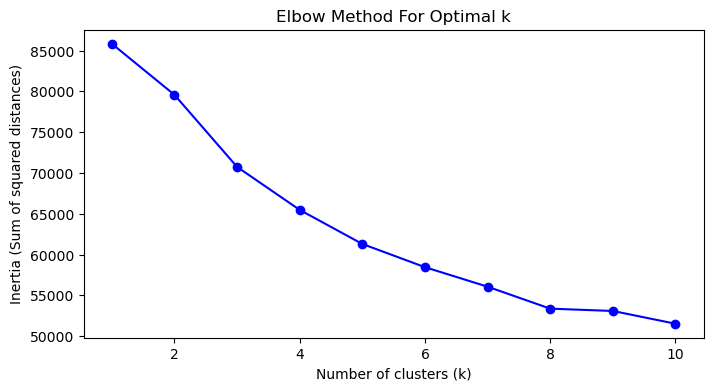

In [44]:
# Determine Optimal Number of Clusters using Elbow Method

inertia = []

K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

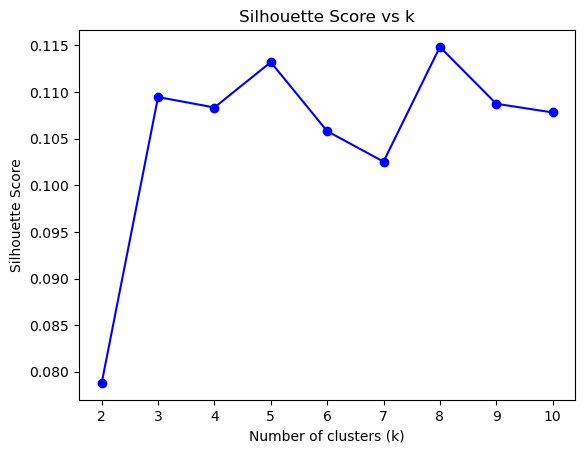

In [46]:
# Determine Optimal Number of Clusters using Silhouette Score

from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    sil_scores.append(silhouette_score(df_scaled, labels))

plt.plot(K, sil_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

In [48]:
# Apply K-means Clustering with k=8

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_scaled)

df['cluster'] = kmeans.labels_

print(df['cluster'].value_counts())

cluster
6    2034
1    1855
4    1428
3    1308
7     949
0     888
2     636
5     439
Name: count, dtype: int64


# Optimal Number of Clusters
Both the Elbow Method and Silhouette Score were used to determine the optimal number of clusters:
- The Elbow Method showed a bend around k=8, after which the reduction in inertia becomes less significant
- The Silhouette Score peaked around k=8, indicating well-defined clusters

Based on these analyses, we selected 8 clusters for our final model.

In [51]:
# Analyze Cluster Characteristics

cluster_summary = df.groupby('cluster').mean()
cluster_summary

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
cluster,,,,,,,,,
0,504.702703,0.174550,7.406532,667.938952,0.867117,0.320930,1.520270,1.784910,0.000000
1,492.502965,0.000000,3.239353,610.745800,1.000000,0.331512,1.511590,2.281941,0.000000
2,513.661950,0.281447,3.970126,2854.894332,0.729560,0.321286,1.600629,1.665094,0.066038
3,495.980887,0.141437,3.542049,600.423464,1.000000,0.333813,1.494648,0.435780,0.000000
4,501.075630,1.292017,3.802521,653.645596,0.912465,0.341682,1.508403,1.878151,0.000000
5,514.214123,1.175399,4.157175,708.991132,0.701595,0.333582,1.437358,1.615034,1.000000
6,504.451819,0.265487,3.748279,634.299046,0.000000,0.330890,1.508850,1.615044,0.000000
7,493.229715,0.000000,4.036881,736.000868,0.699684,0.328419,1.574289,1.623815,1.000000


# Cluster Interpretation
The clusters were interpreted based on their mean feature values:
- Normal clusters (1, 3, 4, 6): Show typical network behavior patterns
- Normal - Heavy Usage (0): Higher session duration and login attempts but within normal parameters
- Suspicious - Long Session (2): Exceptionally long session durations, potentially indicating compromised sessions
- Suspicious clusters (5, 7): Unusual patterns in time access, failed logins, or other metrics

This interpretation helps security teams understand what each cluster represents in terms of network behavior.

In [54]:
# Detect Anomalies

distances = kmeans.transform(df_scaled).min(axis=1)
df['distance_to_center'] = distances

threshold = np.quantile(distances, 0.95)
anomalies = df[df['distance_to_center'] > threshold]

print(f"Number of anomalies detected: {len(anomalies)}")

Number of anomalies detected: 477


In [56]:
# Label Clusters

cluster_labels = {
    0: 'Normal - Heavy Usage',
    1: 'Normal',
    2: 'Suspicious - Long Session',
    3: 'Normal',
    4: 'Normal - Low Risk',
    5: 'Suspicious',
    6: 'Normal',
    7: 'Suspicious'
}

df['cluster_label'] = df['cluster'].map(cluster_labels)

In [58]:
print(anomalies['cluster'].value_counts())

cluster
2    120
6     86
4     75
7     65
0     46
5     44
1     23
3     18
Name: count, dtype: int64


# Anomaly Detection Results
We identified 477 anomalies (approximately 5% of the dataset) using distance-based detection:
- Anomalies are points far from their cluster centers
- Cluster 2 (Suspicious - Long Session) contains the most anomalies (120)
- These anomalies represent potential security threats that warrant investigation

In a real security environment, these anomalies would be flagged for further analysis by security experts.

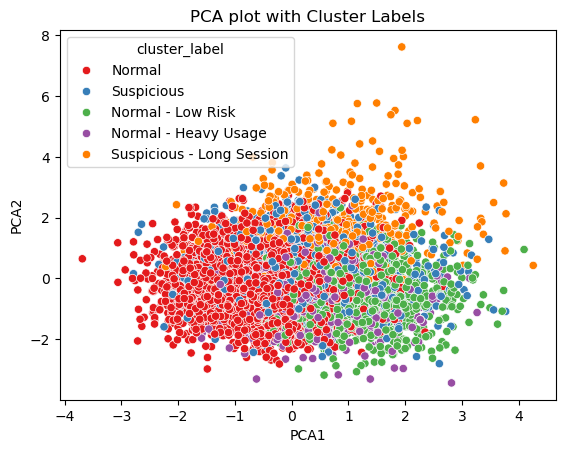

In [61]:
# Visualize Clusters using PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

df['PCA1'], df['PCA2'] = pca_result[:,0], pca_result[:,1]

sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_label', data=df, palette='Set1')
plt.title('PCA plot with Cluster Labels')
plt.show()

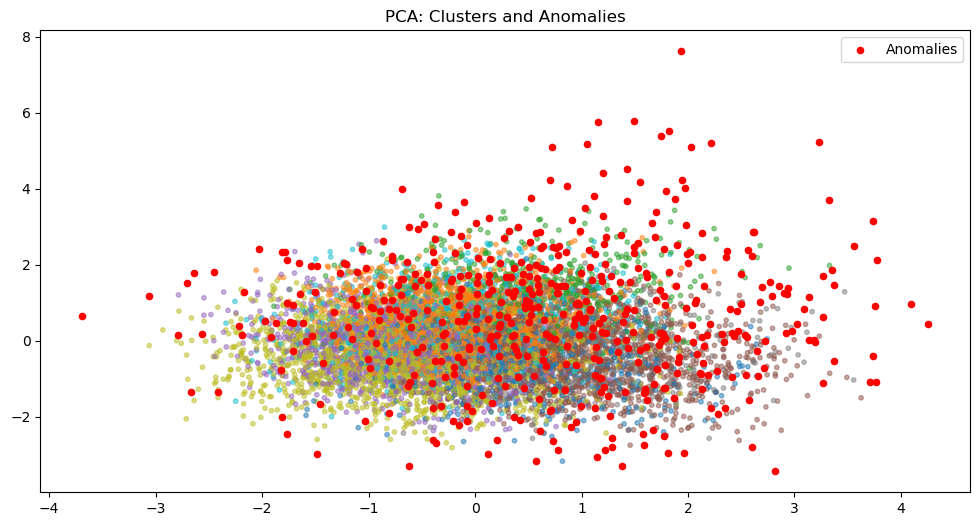

In [63]:
# Visualize Clusters and Anomalies

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(12,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df['cluster'], cmap='tab10', s=10, alpha=0.5)
plt.scatter(pca_result[anomalies.index,0], pca_result[anomalies.index,1], c='red', s=20, label='Anomalies')
plt.legend()
plt.title('PCA: Clusters and Anomalies')
plt.show()


# Results Interpretation
K-means clustering analysis has successfully identified 8 distinct clusters in the cybersecurity intrusion dataset. The clusters represent different patterns of network behavior, with some classified as "Normal" and others as "Suspicious" based on their characteristics.

The analysis detected 477 anomalies (approximately 5% of the dataset), which are data points that deviate significantly from their cluster centers. These anomalies could represent potential security threats or unusual network behavior that warrants further investigation.

From the cluster analysis, I've identified:

- Clusters 1, 3, 4, and 6 as "Normal" network behavior
- Cluster 0 as "Normal - Heavy Usage"
- Cluster 2 as "Suspicious - Long Session" (which also has the highest number of anomalies)
- Clusters 5 and 7 as "Suspicious"

The PCA visualizations show that while some clusters are well-separated, there is some overlap between others, which is expected in real-world cybersecurity data.

# Conclusion
This project demonstrates how unsupervised learning techniques like K-means clustering can be effectively used for cybersecurity intrusion detection. By identifying patterns and anomalies in network traffic, we can:

- Categorize network sessions into meaningful behavioral groups
- Detect unusual activities that might indicate security threats
- Provide security teams with focused areas for investigation

Future work could include:
- Comparing with other clustering algorithms (DBSCAN, Hierarchical)
- Incorporating temporal analysis to detect evolving attack patterns
- Building a real-time monitoring system based on this approach